In [5]:
!pip install torch-geometric
!pip install torch-scatter
!pip install torch-sparse 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torch-scatter: filename=torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl size=274491 sha256=31d3078e5ce347ec912cccb71703fce25a05566eef546f3ffda1fa44f787938c
  Stored in directory: /root/.cache/pip/wheels/dd/57/a3/42ea193b77378ce634eb9454c9bc1e3163f3b482a35cdee4d1
Successfully built torch-scatter


edge prediction：检查node A与node B之间，是否存在connection(edge)

In [6]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

from torch_geometric.utils import negative_sampling
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

In [8]:
# load the Cora dataset
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]
print(dataset.data)

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [9]:
# 查看一个sample
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [10]:
# use train_test_split_edges to create neg and positive edges
# 我们不用给予的mask
data.train_mask = data.val_mask = data.test_mask = data.y = None
# 我们自己定义mask
data = train_test_split_edges(data)
print(data)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[2708, 1433], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])


In [11]:
# Simple autoencoder model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 128)
        self.conv2 = GCNConv(128, 64)

    def encode(self):
        x = self.conv1(data.x, data.train_pos_edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x, data.train_pos_edge_index) # convolution 2

    def decode(self, z, pos_edge_index, neg_edge_index): # only pos and neg edges
        # concatenate pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) 
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 
        return logits

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        # get predicted edge_list
        return (prob_adj > 0).nonzero(as_tuple=False).t()      

In [12]:
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [13]:
def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

In [14]:
def train():
    model.train()

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()
    
    z = model.encode() #encode
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index) # decode
    
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid
        
        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link
        
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score
    return perfs

In [18]:
best_val_perf = test_perf = 0
for epoch in range(1, 20): #range(1, 101):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf))

Epoch: 010, Loss: 0.6497, Val: 0.7388, Test: 0.7551


In [19]:
z = model.encode()
final_edge_index = model.decode_all(z)

In [20]:
final_edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [   0,    1,    2,  ..., 2705, 2706, 2707]])

-----

Edge Label Prediction：predict两个nodes之间的edge的lebel(features)

In [44]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [45]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm
from torch_geometric.datasets import TUDataset

import numpy as np

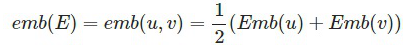

Node2Vec的原理公式：把两个node的embedding找出来，再取**平均值**

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
dataset = "AIDS"
data = TUDataset(".", name=dataset)

In [47]:
print(data)
print("number of classes: ",data.num_classes,"\t\t(active),(inactive)")
print("number of features: ",data.num_features)
print("number of edge labels: ",data.num_edge_labels)
# 此data是分子

AIDS(2000)
number of classes:  2 		(active),(inactive)
number of features:  38
number of edge labels:  3


In [48]:
#取一个sample
data1 = data[1]

# extract edge list
edge_list = data1.edge_index.t().numpy()
print(edge_list[0:10])
#显示前10个edges

[[0 1]
 [0 5]
 [1 0]
 [1 2]
 [1 6]
 [2 1]
 [2 3]
 [3 2]
 [3 4]
 [3 7]]


In [49]:
# extract edge attributes
edge_attr = data1.edge_attr.numpy()
print(edge_attr[0:10])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [50]:
# 把上面edge list，尝试画一个graph看看
import networkx as nx

# build the graph
graph1 = nx.Graph()

for i in range(len(edge_list)):
    u = edge_list[i][0]
    v = edge_list[i][1]
    graph1.add_edge(u,v,label=edge_attr[i])
    
print(graph1.edges(data=True))

[(0, 1, {'label': array([1., 0., 0.], dtype=float32)}), (0, 5, {'label': array([1., 0., 0.], dtype=float32)}), (1, 2, {'label': array([1., 0., 0.], dtype=float32)}), (1, 6, {'label': array([0., 1., 0.], dtype=float32)}), (5, 4, {'label': array([1., 0., 0.], dtype=float32)}), (5, 8, {'label': array([1., 0., 0.], dtype=float32)}), (2, 3, {'label': array([1., 0., 0.], dtype=float32)}), (3, 4, {'label': array([1., 0., 0.], dtype=float32)}), (3, 7, {'label': array([0., 1., 0.], dtype=float32)}), (4, 9, {'label': array([1., 0., 0.], dtype=float32)}), (4, 10, {'label': array([1., 0., 0.], dtype=float32)})]


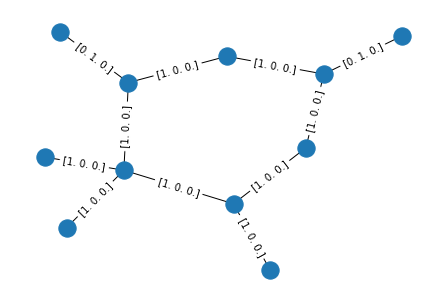

In [51]:
pos = nx.spring_layout(graph1)
nx.draw(graph1,pos)
nx.draw_networkx_edge_labels(graph1,pos,nx.get_edge_attributes(graph1,'label'))
plt.show()

Use only one moleculas compound - 只使用一个分子

In [52]:
data.data

Data(x=[31385, 38], edge_index=[2, 64780], edge_attr=[64780, 3], y=[2000])

In [53]:
data = data[10]
data

Data(edge_index=[2, 166], x=[77, 38], edge_attr=[166, 3], y=[1])

build the graph with train_mask, test_mask, val_mask

In [54]:
np.random.seed(10)
# get the nodes
nodes = data.edge_index.t().numpy()
nodes = np.unique(list(nodes[:,0]) + list(nodes[:,1]))

np.random.shuffle(nodes) # shuffle node order
print(len(nodes))

76


In [55]:
# get train test and val sizes: (70% - 15% - 15%)
train_size = int(len(nodes)*0.7)
test_size = int(len(nodes)*0.85) - train_size
val_size = len(nodes) - train_size - test_size

In [56]:
# get train test and validation set of nodes
train_set = nodes[0:train_size]
test_set = nodes[train_size:train_size+test_size]
val_set = nodes[train_size+test_size:]


print(len(train_set),len(test_set),len(val_set))
print(len(train_set)+len(test_set)+len(val_set) == len(nodes))

print("train set\t",train_set[:10])
print("test set \t",test_set[:10])
print("val set  \t",val_set[:10])

53 11 12
True
train set	 [68 26 21  3 44 41  6 20  2 60]
test set 	 [13 73 51 49 14 67 70 33 58 43]
val set  	 [54 11 16 36 40  0  8 29 28 64]


output可以看出，train set、test set、val set分别的node的数量53、11、12

In [57]:
# build test train val masks

train_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in train_set:
    train_mask[i] = 1.

test_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in test_set:
    test_mask[i] = 1.
    
val_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in val_set:
    val_mask[i] = 1.
    
print("train mask \t",train_mask[0:15])
print("test mask  \t",test_mask[0:15])
print("val mask   \t",val_mask[0:15]) 

train mask 	 tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0])
test mask  	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])
val mask   	 tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0])


In [58]:
# remove from the data what do we not use.

print("befor\t\t",data)
data.x = None
data.edge_attr = None
data.y = None

befor		 Data(edge_index=[2, 166], x=[77, 38], edge_attr=[166, 3], y=[1])


In [59]:
# add masks
data.train_mask = train_mask
data.test_mask = test_mask
data.val_mask = val_mask

print("after\t\t",data)

after		 Data(edge_index=[2, 166], train_mask=[76], test_mask=[76], val_mask=[76])


使用Node2Vec

In [63]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
             context_size=10, walks_per_node=10,
             num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

ImportError: ignored

In [61]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=10)
    return acc

In [62]:
for epoch in range(1, 21): #range(1, 101):
    loss = train()
    #acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

NameError: ignored

In [ ]:
z = model()

visualize node embedding

In [ ]:
# from tensor to numpy
emb_128 = z.detach().cpu().numpy()

In [ ]:
from sklearn.decomposition import PCA
# fit and transform using PCA
pca = PCA(n_components=2)
emb2d = pca.fit_transform(emb_128)


plt.title("node embedding in 2D")
plt.scatter(emb2d[:,0],emb2d[:,1])
plt.show()

Compute edge embedding

In [ ]:
# reload AIDS dataset 
# and pick the same graph


dataset = "AIDS"
data = TUDataset(".", name=dataset)
data = data[10]

In [ ]:
# convert edge attributes from categorical to numerical
edge_attr_cat = data.edge_attr.numpy()
print("Categorical edge attributes:\n",edge_attr_cat[:3])

edge_attr = []
for i in edge_attr_cat:
    edge_attr.append(np.nonzero(i)[0][0])

print("\n\nNumerical edge attributes:\n",edge_attr[:3])

In [ ]:
# compute edge embedding

edge_embedding = []
for u,v in data.edge_index.t():
    edge_embedding.append(np.mean([emb_128[u],emb_128[v]],0))

visualize edge embedding

In [ ]:
import pandas as pd
# fit and transform using PCA
pca = PCA(n_components=2)
edge_emb2d = pca.fit_transform(edge_embedding)



df = pd.DataFrame(dict(edge_att=edge_attr))
colors = {0:"red",1:"blue"}
plt.title("edge embedding in 2D")
plt.scatter(edge_emb2d[:,0],edge_emb2d[:,1],c=df.edge_att.map(colors))
plt.show()

# not so good but we are using PCA to reduce the dim from 128 to 2

Use RandomForestClassifier with 10-fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(max_depth=7,random_state=10)


scores = cross_val_score(clf, edge_embedding, edge_attr, cv=10)
np.mean(scores)